In [1]:
%load_ext Cython

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from tqdm import tqdm
from scipy.special import erfc
import boost_histogram as bh

from lmfit.models import *
from lmfit import Model

import inspect

In [17]:
golden_df = pd.read_csv("/Users/tylern/Data/e1d/gr.csv")
print(len(golden_df))
#golden_df = golden_df.groupby(golden_df['run_num'], as_index=False).aggregate({'run_num': 'first', 'num_elec': 'sum', 'num_of_events': 'sum', 'total_q': 'sum'})
golden_df['ratio'] = golden_df['num_elec'] / golden_df['total_q']
golden_df['run'] = golden_df.run_num*10 + golden_df.file_num
golden_df = golden_df.sort_values(by=['run_num', 'file_num']).reset_index()
golden_df = golden_df.sort_values(by=['run_num']).reset_index()
golden_df['sum_q'] = np.cumsum(golden_df['total_q'])

golden_df.head()

532


,level_0,index,run_num,file_num,num_elec,num_of_events,total_q,ratio,run,sum_q
0,0,0,22848,0,105,118557.0,2.623000,40.030501,228480,2.623000
1,1,1,22848,11,90,87643.0,31.979300,2.814321,228491,34.602299
2,2,2,22853,0,120,122596.0,2.793800,42.952253,228530,37.396099
3,3,3,22853,1,141,122954.0,5.663800,24.894946,228531,43.059900
4,4,4,22853,2,133,122566.0,8.549899,15.555739,228532,51.609799


In [18]:
run_list = pd.read_csv("/Users/tylern/Data/e1d/out.csv").rename(columns={"Run Id": "run_num"})
run_list['Number of Events'] = pd.to_numeric(run_list['Number of Events'], errors='coerce')
run_list.head()

,run_num,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,22678,2000-01-31 10:16:00.0,1645.03,0.0,0.977,0,27380.0,e_calib_misc,56Fe
1,22679,2000-01-31 10:29:00.0,1645.03,0.0,0.977,0,32546.0,e_calib_misc,56Fe
2,22680,2000-01-31 10:35:00.0,1645.03,0.0,0.977,0,555588.0,e_calib_misc,56Fe
3,22681,2000-01-31 14:47:00.0,1645.03,0.0,-0.977,0,980.0,e_calib_misc,other
4,22682,2000-01-31 14:52:00.0,1645.03,0.0,0.977,0,1133.0,e_calib_misc,other


In [19]:
golden = pd.merge(golden_df, run_list, on='run_num')
#golden = golden_df
empty = golden[golden.Target == "empty"]
golden = golden[(golden.Target == "H2_full") & (golden["Run Type"] == 'beam_electron')]
golden.dropna(inplace=True)
print(len(golden))
golden.head(10)

530


,level_0,index,run_num,file_num,num_elec,num_of_events,total_q,ratio,run,sum_q,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,0,22848,0,105,118557.0,2.623000,40.030501,228480,2.623000,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
1,1,1,22848,11,90,87643.0,31.979300,2.814321,228491,34.602299,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
2,2,2,22853,0,120,122596.0,2.793800,42.952253,228530,37.396099,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
3,3,3,22853,1,141,122954.0,5.663800,24.894946,228531,43.059900,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
4,4,4,22853,2,133,122566.0,8.549899,15.555739,228532,51.609799,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
5,5,5,22853,3,141,124287.0,11.448200,12.316346,228533,63.057999,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
6,6,6,22853,4,125,124488.0,14.368800,8.699404,228534,77.426799,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
7,7,7,22853,5,144,124018.0,17.236900,8.354170,228535,94.663699,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
8,8,8,22853,6,113,123500.0,20.150900,5.607690,228536,114.814599,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
9,9,9,22853,7,119,122935.0,22.978901,5.178664,228537,137.793500,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full


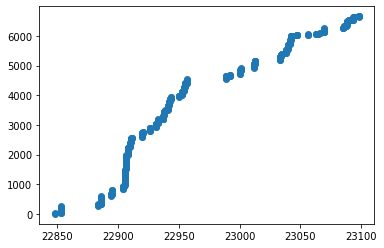

In [20]:
plt.scatter(golden['run_num'], np.cumsum(golden['total_q']), alpha=0.9);

Parameters([('amplitude', <Parameter 'amplitude', value=171634560.58552843, bounds=[-inf:inf]>), ('center', <Parameter 'center', value=-4146.301772189941, bounds=[-inf:inf]>), ('sigma', <Parameter 'sigma', value=1374.3155459997013, bounds=[0.0:inf]>), ('fwhm', <Parameter 'fwhm', value=3236.2657340310166, bounds=[-inf:inf], expr='2.3548200*sigma'>), ('height', <Parameter 'height', value=49822.82748586106, bounds=[-inf:inf], expr='0.3989423*amplitude/max(2.220446049250313e-16, sigma)'>)])


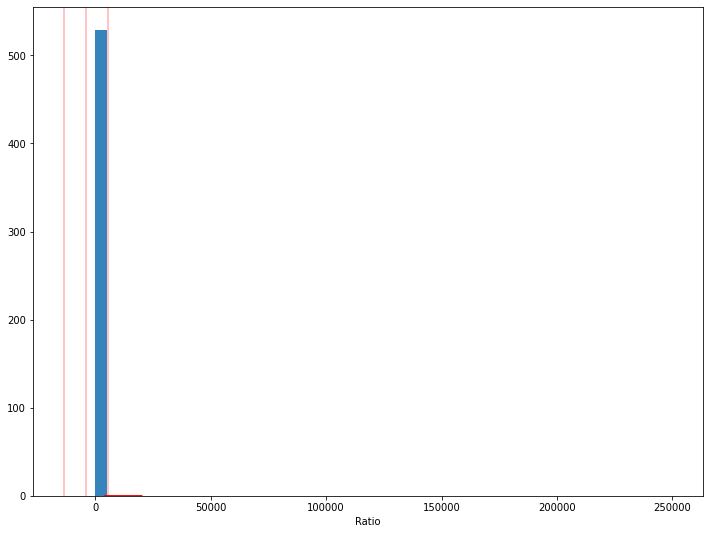

In [21]:
SIGMA = 3
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
bin_heights, bin_borders, _ = plt.hist(golden['ratio'], bins=50, histtype='stepfilled', alpha=0.9, range=[0, 250_000])#, range=[40_000, 80_000])

x = bin_borders[:-1]
y = bin_heights

mod = GaussianModel()
pars = mod.guess(y, x=x)
pars['center'].set(value=6_000)
out = mod.fit(y, pars, x=x)

xs=np.linspace(4_000, 20_000, 140)

plt.plot(xs, out.eval(x=xs), 'r-', label='best fit')

center = out.params['center'].value
fwhm = out.params['fwhm'].value

print(out.params)

plt.axvline(x=center, c='r', alpha=0.3)
plt.axvline(x=center+SIGMA*fwhm, c='r', alpha=0.3)
plt.axvline(x=center-SIGMA*fwhm, c='r', alpha=0.3)

plt.ylim(0)
plt.xlabel('Ratio')
plt.show()

-4146.301772189941


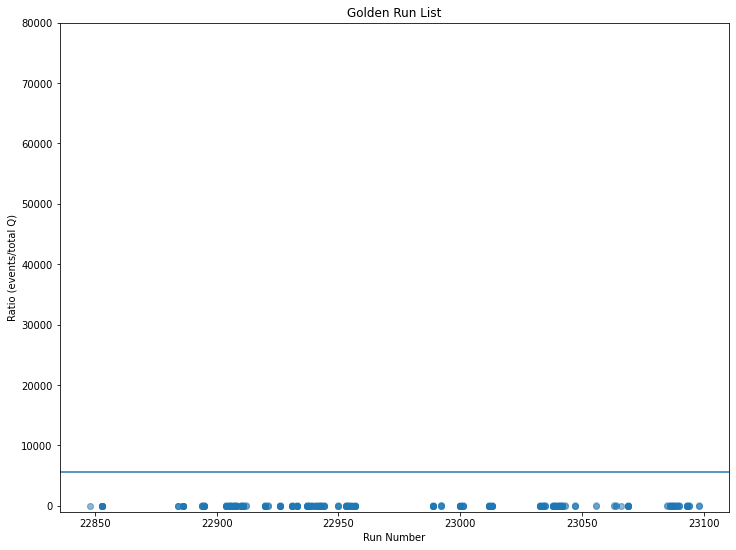

In [22]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden['run_num'], golden['ratio'], alpha=0.3)
print(center)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([-1000, 80_000])
plt.show()


In [9]:
runs = golden[(golden['ratio'] >= center-SIGMA*fwhm) & (golden['ratio'] <= center+SIGMA*fwhm)].run_num
cut_out = golden[~golden.run_num.isin(runs.values)]
after_cut = golden[golden.run_num.isin(runs.values)]
print(len(after_cut))
after_cut.head()

531


,level_0,index,run_num,file_num,num_elec,num_of_events,total_q,ratio,run,sum_q,Start Date,Beam Energy,Beam Current Request,Torus Current,Mini-Torus Current,Number of Events,Run Type,Target
0,0,0,22848,0,105,118557.0,2.623000,45199.010379,228480,2.623000,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
1,1,1,22848,11,90,87643.0,31.979300,2740.616625,228491,34.602299,2000-02-04 02:20:00.0,4817.26,5.0,3376.8,5996,5061135.0,beam_electron,H2_full
2,2,2,22853,0,120,122596.0,2.793800,43881.453715,228530,37.396099,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
3,3,3,22853,1,141,122954.0,5.663800,21708.745860,228531,43.059900,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full
4,4,4,22853,2,133,122566.0,8.549899,14335.373850,228532,51.609799,2000-02-04 05:30:00.0,4817.26,5.0,3376.8,5996,4961938.0,beam_electron,H2_full


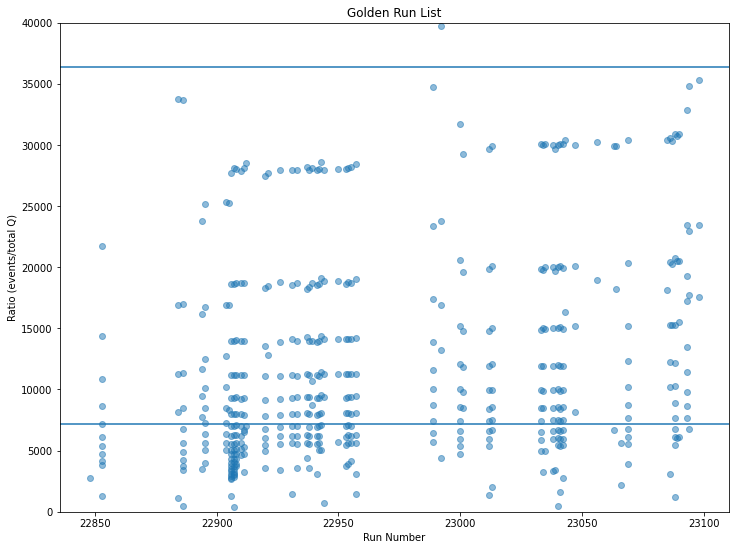

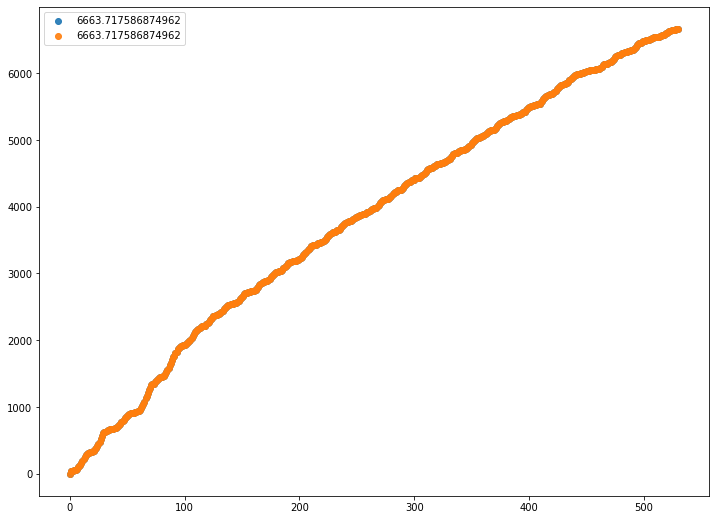

6663.717586874962


In [10]:
fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(after_cut['run_num'], after_cut['ratio'], alpha=0.5)
plt.scatter(cut_out['run_num'], cut_out['ratio'], alpha=0.5)
plt.scatter(empty['run_num'], empty['ratio'], alpha=0.5)
plt.axhline(y=center)
plt.axhline(y=center+SIGMA*fwhm)
plt.axhline(y=center-SIGMA*fwhm)
plt.xlabel('Run Number')
plt.title('Golden Run List')
plt.ylabel('Ratio (events/total Q)')
#plt.ylim([40_000, 80_000])
plt.ylim([0, 40_000])
plt.show()


fig = plt.figure(num=None, figsize=(12,9), facecolor='w', edgecolor='k')
plt.scatter(golden.index, np.cumsum(golden['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(golden.total_q))}')
plt.scatter(after_cut.index, np.cumsum(after_cut['total_q']), alpha=0.9, label=f'{np.max(np.cumsum(after_cut.total_q))}')
plt.legend()
plt.show()


#print(Q_tot := np.max(np.cumsum(after_cut.total_q)))
print(Q_tot := np.max(np.cumsum(golden.total_q)))

In [11]:
def luminosity(Q_tot=2822.038E-6):
    Q_tot *= 1E-6
    # Q_tot = 15623.89E-6  # mCE-6 -> C
    # Q_tot = 2822.038E-6  # mCE-6 -> C
    l = 5  # cm
    rho = 0.0708  # g/cm3
    Avigadro = 6.022E23  # mol^−1
    qe = 1.602E-19  # C
    MH = 1.007  # g/mol
    conv_cm2_to_fm2 = 1E-39 # From wolfram alpha
    conv_cm2_to_mubarn = 1E-30

    return (Q_tot*l*rho*Avigadro)/(qe*MH) * conv_cm2_to_mubarn

In [12]:
print(f'{Q_tot:0.10f}')
print(f'{luminosity(Q_tot=Q_tot):0.2e}')
print(f'{luminosity():0.2e}')

6663.7175868750
8.81e+09
3.73e+03


In [13]:
from shutil import copyfile
import os
print(len(after_cut.run_num.unique()))
for run in after_cut.run_num.unique():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root golden_run/;"
    print(command)
    #x = os.system(command)
    #print(x)
    

61
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22848_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22853_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22884_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22886_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22894_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22895_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22904_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22905_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22906_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22907_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22908_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22910_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22911_*.root golden_run/;
ln -s /work/gothelab/clas6/e1d/data/v2/h10_r22912_*.root golden_run/;
ln -s /work/gothe

In [14]:
for run in empty.run_num.unique():
    #fil = int(fil)
    #src = f'/Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_{fil:02d}.root'
    #dst = f'/Users/tylern/Data/e1d/golden_run/h10_r{run}_{fil:02d}.root'
    # copyfile(src, dst)
    #command = f"rsync workstation_tunnel:/work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    # command = f"rsync /Volumes/LaCiE/physics/e1d/v2/H2_full/h10_r{run}_*.root /Users/tylern/Data/e1d/golden_run"
    command = f"ln -s /work/gothelab/clas6/e1d/data/v2/h10_r{run}_*.root empty/;"
    print(command)
    #x = os.system(command)
    #print(x)
    